In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1785765080772677405
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3663069184
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16032249369564632949
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

<center><h1>Dogs🐶 Vs Cats🐱</h1></center>

<img src ="https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg">
    
Problem Statement : 
    
    Create an algorithm to classify whether images contain either dog or a cat.
    
More Insights About PS : 
    
    Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof). HIPs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.
    
Application Area : 
    
    CAPTCHA Application 


*I am new in Computer Vision field any feedback is much appreciated !

Flow of this Notebook :

    1. Import necessay libraries 
    
    2. Prepare training dataset & Visualize it.
    
    3. Split dataset into training and validation set
    
    4. Build a predictive model
    
    5. Fit the predictive model onto the training data
    
    6. Prepare testing dataset & Visualize it.
    
    7. Predict on testing data
    
    8. Submission 

# **1. IMPORTING NECESSARY LIBRARIES** 📚 ⬇

In [4]:
import numpy as np
import pandas as pd

import os
import random 

import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image
from sklearn.model_selection import train_test_split

# **2. PREPARING TRAINING DATA** 📁

First thing first we need to create a dataset. Since the input is in file format.

In [5]:
import zipfile

with zipfile.ZipFile('../Dogs-Vs-Cats/Dataset/test1.zip', 'r') as zip_ref:
    
    zip_ref.extractall('./')
    
with zipfile.ZipFile('../Dogs-Vs-Cats/Dataset/train.zip', 'r') as zip_ref:
    
    zip_ref.extractall('./')

In [6]:
# Read input files to create training dataset
filenames = os.listdir('./train')

categories = []

for filename in filenames:
    
    category = filename.split('.')[0]
    
    if(category == 'dog'):
        
        categories.append('dog')
        
    else:
        
        categories.append('cat')
        
# create a dataframe

df = pd.DataFrame({
        
        'filename' : filenames,
    
        'category' : categories
    
    })

In [7]:
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [8]:
df.tail()

,filename,category
24995,dog.9995.jpg,dog
24996,dog.9996.jpg,dog
24997,dog.9997.jpg,dog
24998,dog.9998.jpg,dog
24999,dog.9999.jpg,dog


In [9]:
df['category'].value_counts()

cat    12500
dog    12500
Name: category, dtype: int64

**VISUALIZING TRAINING DATASET** 📊

<AxesSubplot:>

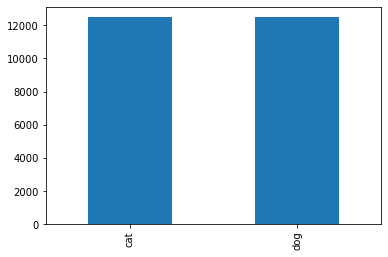

In [10]:
df['category'].value_counts().plot(kind = 'bar')

This dataset contains 25,000 images of dogs and cats (12,500 from each class).

**See sample image** 🐕

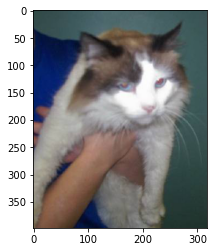

In [11]:
# sample image

sample = random.choice(filenames)

image = image.load_img('./train/' + sample)

plt.imshow(image)

# **3. SPLITTING DATASET INTO TRAINING AND VALIDATION SET** 

We are done with the first step of creating a dataset. Now we have to split this dataset into training and validation dataset.

In [12]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42)

train_df = train_df.reset_index(drop=True)

validate_df = validate_df.reset_index(drop=True)

In [13]:
train_df.head()

,filename,category
0,dog.8479.jpg,dog
1,dog.876.jpg,dog
2,cat.10915.jpg,cat
3,dog.10127.jpg,dog
4,cat.11377.jpg,cat


In [14]:
validate_df.head()

,filename,category
0,cat.493.jpg,cat
1,dog.9112.jpg,dog
2,cat.745.jpg,cat
3,dog.11022.jpg,dog
4,dog.11363.jpg,dog


<AxesSubplot:>

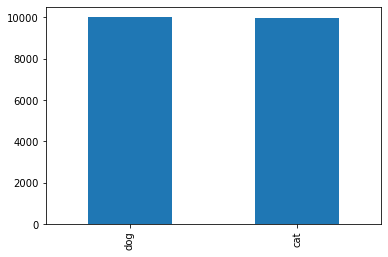

In [15]:
train_df['category'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

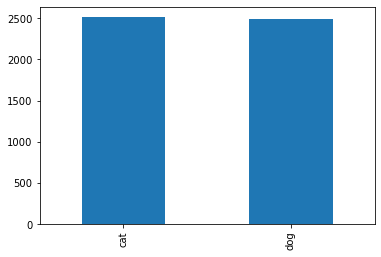

In [16]:
validate_df['category'].value_counts().plot(kind = 'bar')

In [17]:
total_train = train_df.shape[0]

total_validate = validate_df.shape[0]

print("Total number of example in training dataset : {0}".format(total_train))

print("Total number of example in validation dataset : {0}".format(total_validate))

Total number of example in training dataset : 20000
Total number of example in validation dataset : 5000


# **4. BUILD A PREDICTIVE MODEL** 🏗

In [18]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

from tensorflow.keras import optimizers

First Model- Our first model will be the convnet which is stack of alternated conv2D(with relu activation) and MaxPooling2D layers.

- Conv Layer -> The matrix representation of the input image is multiplied element-wise with the kernel(filter) to produce a                  feature map, also known as a convolved feature or an activation map.The aim of this step is to reduce the size                  of the image and make processing faster and easier.
               
               Output of this layer must be equal to:- shape = math.floor(((n+2p-f)/s)+1, ((n+2p-f)/s)+1)


- Pooling Layer -> Pooling enables the CNN to detect features in various images irrespective of the difference in lighting in                      the pictures and different angles of the images.
                   
               Output of maxpooling layer :- shape = math.floor(((n-f)/s)+1, ((n-f)/s)+1)
             
             
- Flattening -> Flattening involves transforming the entire pooled feature map matrix into a single column which is then fed to                 the neural network for processing.

In [19]:
class Model:
    
    def __init__(self, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
        
        self.IMG_WIDTH = IMG_WIDTH
        
        self.IMG_HEIGHT = IMG_HEIGHT
               
        self.IMG_CHANNELS = IMG_CHANNELS
    
    def create_model_one(self):
        
        model_one = Sequential()
        
        # Adding Layers to create a convolutional mask/kernel that is wind with layers input which helps produce a tensor of outputs
        
        # Layer 1
        model_one.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
        
        model_one.add(MaxPooling2D((2,2)))
        
        # Layer 2
        model_one.add(Conv2D(64, (3,3), activation = 'relu'))
        
        model_one.add(MaxPooling2D((2,2)))
        
        # Layer 3
        model_one.add(Conv2D(128, (3,3), activation = 'relu'))
        
        model_one.add(MaxPooling2D((2,2)))
               
        # Layer 4
        model_one.add(Conv2D(128, (3,3), activation = 'relu'))
        
        model_one.add(MaxPooling2D((2,2)))
           
        model_one.add(Flatten())
                      
        model_one.add(Dense(512, activation = 'relu'))
        
        model_one.add(Dense(1, activation = 'sigmoid'))
                      
        return model_one
    
    def create_model_two(self):
        
        model_two = Sequential()
        
        # Adding Layers to create a convolutional mask/kernel that is wind with layers input which helps produce a tensor of outputs
        
        # Layer 1
        model_two.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
        
        model_two.add(MaxPooling2D((2,2)))
        
        # Layer 2
        model_two.add(Conv2D(64, (3,3), activation = 'relu'))
        
        model_two.add(MaxPooling2D((2,2)))
        
        # Layer 3
        model_two.add(Conv2D(128, (3,3), activation = 'relu'))
        
        model_two.add(MaxPooling2D((2,2)))
               
        # Layer 4
        model_two.add(Conv2D(128, (3,3), activation = 'relu'))
        
        model_two.add(MaxPooling2D((2,2)))
           
        model_two.add(Flatten())
        
        # DropoutLayer for preventing model from overfitting
        model_two.add(Dropout(0.5))
                      
        model_two.add(Dense(512, activation = 'relu'))
        
        model_two.add(Dense(1, activation = 'sigmoid'))
                      
        return model_two
    
        
        

In [20]:
IMG_WIDTH = 150

IMG_HEIGHT = 150

IMG_CHANNELS = 3

model = Model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

**Model 1**

In [21]:
model_1 = model.create_model_one()

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Compiling Model 1

Since it is a two class classification problem, therefore using binary_crossentropy as loss and using RMSprop as optimizer because we ended the network with a single sigmoidal unit.

In [22]:
from tensorflow.keras import optimizers

model_1.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics =['acc'])

📌 Currently data is in in jpeg format, so in order to feed those images to Neural Network we need to do the following steps

Step 1 - Read the image file

Step 2 - Decode those JPEG content to RGB grids of pixels

Step 3 - Convert these into floating-point tensors

Step 4 - Rescale the pixel values from range [0-255] to [0-1] as NN prefers to deal with smaller input values.

In [23]:
from keras.preprocessing.image import ImageDataGenerator

<div class="alert alert-block alert-info">
📌Generators in Python -: 
A Python generator is an object that acts as an iterator. Generators are built using the yield operator.
</div>

In [24]:
train_imgdatagen = ImageDataGenerator(rescale = 1./255)

valid_imgdatagen = ImageDataGenerator(rescale = 1./255)

In [25]:
train_generator_m1 = train_imgdatagen.flow_from_dataframe(
                    train_df,
                    
                    "./train", 
                    
                    x_col='filename',
    
                    y_col='category',
                    
                    target_size = (150, 150), # resize image to 150x150
                    
                    batch_size = 20,
    
                    class_mode = 'binary'
                  )


validation_generator_m1 = train_imgdatagen.flow_from_dataframe(
                    validate_df,
    
                    "./train", 
                    
                    x_col='filename',
    
                    y_col='category',
                    
                    target_size = (150, 150), # resize image to 150x150
                    
                    batch_size = 20,
    
                    class_mode = 'binary'
                  )


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


That's correct training data contains 20000 images with 2 classes and also validation data contains 5000 images with 2 classes.

Now lets look at the output of these generators :

In [26]:
for data_batch, labels_batch in train_generator_m1:
    
    print('Data batch shape: {0}'. format(data_batch.shape))
    
    print('Labels batch shape: {0}'. format(labels_batch.shape))
    
    break

Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20,)


There are 20 samples in each batch.

**Model 2 (Using Data augementation)**

📌 In this approach we try to generate more training samples from existing training data, by augementing the samples through a number of random transformation that yields believable looking images. The goal of this approach is that our model should not see the exact same image at training time which as a result helps our model to more aspects of data and generalize better.

But how can we do that? 🧐

This can be done by configuring some random changes on images using **ImageDataGenerator**.

If we use the below generator then we cant not completely get rid of overfitting

In [27]:
train_imgdatagen_m2 = ImageDataGenerator(
                     rescale = 1./255,
    
                     rotation_range = 15,
    
                     width_shift_range = 0.1,
    
                     height_shift_range = 0.1,
    
                     shear_range = 0.1,
    
                     zoom_range = 0.2,
    
                     horizontal_flip = True
                    )

valid_imgdatagen_m2 = ImageDataGenerator(
                             rescale = 1./255
                         )

In [28]:
model_2 = model.create_model_two()

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [29]:
model_2.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics =['acc'])

In [30]:
train_generator_m2 = train_imgdatagen_m2.flow_from_dataframe(
                    train_df,
                    
                    "./train", 
                    
                    x_col='filename',
    
                    y_col='category',
                    
                    target_size = (150, 150), # resize image to 150x150
                    
                    batch_size = 32,
    
                    class_mode = 'binary'
                  )


validation_generator_m2 = valid_imgdatagen_m2.flow_from_dataframe(
                    validate_df,
    
                    "./train", 
                    
                    x_col='filename',
    
                    y_col='category',
                    
                    target_size = (150, 150), # resize image to 150x150
                    
                    batch_size = 32,
    
                    class_mode = 'binary'
                  )


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


**MODEL 3**

**Can we get more accuracy? 💭**

Let's try to build one more predictive model using a pretrained model.

**But why pretrained model? 🤷‍♂️**

Because probability of learned features across different problems is a key advantage of deep learning compared to many olders, shallow-learning approaches and it makes deep learning very effective for small-data problems.

In [31]:
from tensorflow.keras.applications import VGG16

In [32]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

`The final feature map has a shape (4, 4, 512). That's the feature on top of which we will stick densely connected classifier.

Adding a densely connected classifier on top of convolution base

In [33]:
model_3 = Sequential()

model_3.add(conv_base)

model_3.add(Flatten())

model_3.add(Dense(256, activation = 'relu'))

model_3.add(Dense(1, activation = 'sigmoid'))

In [34]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Freezing conv_base

In [35]:
print("The number of trainable weights before freezing the conv base: ", len(model_3.trainable_weights))

The number of trainable weights before freezing the conv base:  30


In [36]:
conv_base.trainable = False

print("The number of trainable weights after freezing the conv base: ", len(model_3.trainable_weights))

The number of trainable weights after freezing the conv base:  4


Fine Tuning : Freezing layers of conv_base upto specific one

<div class="alert alert-block alert-info">
📌 Fine-tuning consists of unfreezing a few of the top layers of frozen model base used for feature extraction and jointly training both the newly added part of the model(in this case, the FCC) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem.
</div>

In [37]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    
    if layer.name == 'block5_conv1':
        
        set_trainable = True
        
    if set_trainable:
        
        layer.trainable = True
        
    else:
        
        layer.trainable = False

Callbacks

In [38]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [39]:
earlystop = EarlyStopping(patience=10)

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [41]:
callbacks = [earlystop, learning_rate_reduction]

In [42]:
model_3.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-5), metrics =['acc'])

# **5. FIT THE MODEL ONTO THE TRAINING DATA** 📈

MODEL 1

In [43]:
from PIL import Image

In [44]:
history_1 = model_1.fit(
            train_generator_m1,
    
            epochs = 30,
    
            steps_per_epoch = 100,
            
            validation_data = validation_generator_m1,
    
            validation_steps = 50
            )

TypeError: Protocols cannot be instantiated

In [ ]:
print(np.mean(history_1.history['acc']))

In [ ]:
print(np.mean(history_1.history['val_acc']))

Saving the model

In [ ]:
model_1.save('model_1.h5')

**Visualizing Loss and accuracy during training 📊**

In [ ]:
plt.plot(history_1.history['acc'], color = 'black')

plt.plot(history_1.history['val_acc'], color = 'blue')

plt.title('Training and validation accuracy of model 1')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.show()

plt.plot(history_1.history['loss'], color = 'black')

plt.plot(history_1.history['val_loss'], color = 'blue')

plt.title('Training and validation loss of model 1')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.show()

MODEL 2

In [ ]:
history_2 = model_2.fit(
            train_generator_m2,
    
            epochs = 100,
    
            steps_per_epoch = 100,
            
            validation_data = validation_generator_m2,
    
            validation_steps = 50,
    
            callbacks = [earlystop, learning_rate_reduction]
            )

In [ ]:
print(np.mean(history_2.history['acc']))

In [ ]:
print(np.mean(history_2.history['val_acc']))

In [ ]:
model_2.save('model_2.h5')

In [ ]:
plt.plot(history_2.history['acc'], color = 'black')

plt.plot(history_2.history['val_acc'], color = 'blue')

plt.title('Training and validation accuracy of model 2')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.show()

plt.plot(history_2.history['loss'], color = 'black')

plt.plot(history_2.history['val_loss'], color = 'blue')

plt.title('Training and validation loss of model 2')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.show()

MODEL 3

Using the same ImageGenerators of model 2

In [ ]:
history_3 = model_3.fit(
            train_generator_m2,
    
            epochs = 30,
    
            steps_per_epoch = 100,
            
            validation_data = validation_generator_m2,
    
            validation_steps = 50,
            
            callbacks = callbacks
            )

In [ ]:
print(np.mean(history_3.history['acc']))

In [ ]:
print(np.mean(history_3.history['val_acc']))

In [ ]:
model_3.save('model_3.h5')

In [ ]:
plt.plot(history_3.history['acc'], color = 'black')

plt.plot(history_3.history['val_acc'], color = 'blue')

plt.title('Training and validation accuracy of model 3')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.show()

plt.plot(history_3.history['loss'], color = 'black')

plt.plot(history_3.history['val_loss'], color = 'blue')

plt.title('Training and validation loss of model 3')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.show()

# **6. PREPARE TESTING DATASET AND VISULAIZE IT** 📷

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('model_3.h5')

In [ ]:
test_filenames = os.listdir('./test1')

test_df = pd.DataFrame(
         {
             'id' : test_filenames
         } 
         )

In [ ]:
test_df.head()

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_dataframe(    
                    test_df,
    
                    "./test1", 
                    
                    x_col='id',
    
                    y_col=None,
                    
                    target_size = (150, 150), # resize image to 150x150
                    
                    batch_size = 20,
    
                    class_mode = None,
    
                    shuffle=False,
    
                    validate_filenames=False
                  )

# **7. PREDICTING ON TESTING DATA** 📈🤞

In [ ]:
predictions = model.predict(test_generator)

In [ ]:
pred = [1 if p > 0.5 else 0 for p in predictions]

test_df['category'] = pred

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
label_map = dict((v,k) for k,v in train_generator_m2.class_indices.items())

test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df['category'].value_counts().plot.bar()

# **8. SUBMISSION** ✌🙌🎉

In [ ]:
submission_df = test_df.copy()

submission_df['id'] = submission_df['id'].str.split('.').str[0]

submission_df['label'] = submission_df['category']

submission_df.drop(['id', 'category'], axis=1, inplace=True)

submission_df.to_csv('submission.csv', index=False)